# I. Tổng quan bộ dữ liệu

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer,  KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [163]:
# Đoc file dữ liệu từ drive
data = pd.read_csv('/content/drive/My Drive/P28/Sample code/Datasample.csv')

In [ ]:
# Tạo 1 bản copy
df = data.copy()
# Hiển thị 5 dòng đầu tiên
df.head(5)

In [ ]:
# Hiển thị thông tin chung (tên cột, non-null count, dtype: định dạng dữ liệu)
df.info()

Dữ liệu tồn tại cả dạng object và numeric -> cần chia để xử lí

In [ ]:
# Lọc các cột có kiểu dữ liệu là object
object_columns = df.select_dtypes(include=['object']).columns

# In ra unique values trong các cột có kiểu dữ liệu là object
for column in object_columns:
    unique_values = df[column].unique()
    print(f"Unique values in {column} column: {unique_values}")

In [165]:
# Hiển thị các cột có giá trị thiếu và số unique value từng cột
missing_values = df.isnull().sum()
unique_values = df.nunique()

result_df = pd.DataFrame({
    'Cột': missing_values.index,
    'Missing Values': missing_values.values,
    'Tỷ Lệ Missing': (missing_values / df.shape[0] * 100).values,
    'Số Unique Values': unique_values[missing_values.index].values,
    'Tỷ Lệ Unique': (unique_values / df.shape[0] * 100).values
})

# Tính tỉ lệ phần trăm của giá trị duy nhất mà xuất hiện nhiều nhất trong mỗi cột
max_value_percentage = []
for col in missing_values.index:
    max_value_count = df[col].value_counts().max()
    max_percentage = (max_value_count / df.shape[0]) * 100
    max_value_percentage.append(max_percentage)

result_df['Unique Value Nhiều Nhất (%)'] = max_value_percentage
# Sắp xếp theo tỷ lệ giảm dần
df = result_df.sort_values(by='Unique Value Nhiều Nhất (%)', ascending=False)
# In ra DataFrame
print(df.to_string(index=False))

        Cột  Missing Values  Tỷ Lệ Missing  Số Unique Values  Tỷ Lệ Unique  Unique Value Nhiều Nhất (%)
        f46               0          0.000                45         0.045                       99.567
        f20               0          0.000                94         0.094                       99.128
        f14               0          0.000                54         0.054                       98.772
        f12               0          0.000                60         0.060                       97.400
        f16               0          0.000                52         0.052                       96.880
        f92            1732          1.732                 2         0.002                       94.256
        f93            1732          1.732                 2         0.002                       93.572
        f90            1732          1.732                 2         0.002                       92.571
        f38               0          0.000              3168    

Cột Customer ID không có ý nghĩa -> Xóa

Cột Customer ID có 10000 unique value -> Không có duplicated rows

Cột y có missing value tỉ lệ nhỏ -> Đề xuất loại bỏ missing value

In [170]:
# Xóa cột Customer ID
df = df.drop("Customer_ID", axis=1)
# Xóa các dòng chứa missing value của cột y
df = df.dropna(subset=["y"])

Tồn tại các cột có 1 missing value -> Đề xuất loại bỏ dòng có chứa missing value đó

Không có biến nào có 1 unique value -> giữ nguyên

In [171]:
# Tìm các cột có đúng 01 giá trị thiếu
columns_with_one_missing_value = df.columns[df.isnull().sum() == 1]

# Loại bỏ các dòng có giá trị thiếu trong cột 'f73', 'f75', 'f76', 'f72', 'f97'
df = df.dropna(subset=columns_with_one_missing_value)

Tồn tại cột mà có số unique value chiếm nhiều nhất từ 90% trở lên -> Gần như cả cột đều là 1 giá trị + Đa số các cột này đều có tỉ lệ missing value và tỉ lệ unique value thấp ---> Đề xuất loại bỏ cột

In [172]:
# Lọc các cột theo điều kiện
filtered_columns = result_df[
    (result_df['Tỷ Lệ Unique'] < 1) & (result_df['Unique Value Nhiều Nhất (%)'] > 90)
]

# In ra DataFrame sau khi lọc
print("Các cột cần loại bỏ:")
print(filtered_columns.to_string(index=False))

# Loại bỏ các cột có ít hơn 1% giá trị duy nhất và có tỷ lệ giá trị duy nhất nhiều nhất từ 90% trở lên
columns_to_remove = filtered_columns['Cột'].tolist()
df = df.drop(columns=columns_to_remove, axis=1)


Các cột cần loại bỏ:
Cột  Missing Values  Tỷ Lệ Missing  Số Unique Values  Tỷ Lệ Unique  Unique Value Nhiều Nhất (%)
f12               0          0.000                60         0.060                       97.400
f14               0          0.000                54         0.054                       98.772
f16               0          0.000                52         0.052                       96.880
f20               0          0.000                94         0.094                       99.128
f36               0          0.000               236         0.236                       91.058
f40               0          0.000               257         0.257                       90.394
f46               0          0.000                45         0.045                       99.567
f79            1732          1.732                 2         0.002                       90.153
f90            1732          1.732                 2         0.002                       92.571
f92            1732

In [173]:
# In ra kết quả sau bước data cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98267 entries, 0 to 99999
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      97919 non-null  float64
 1   f2      97919 non-null  float64
 2   f3      97919 non-null  float64
 3   f4      97919 non-null  float64
 4   f5      97919 non-null  float64
 5   f6      97919 non-null  float64
 6   f7      97919 non-null  float64
 7   f7.1    97919 non-null  float64
 8   f8      97919 non-null  float64
 9   f9      97391 non-null  float64
 10  f10     97391 non-null  float64
 11  f11     98267 non-null  float64
 12  f13     98267 non-null  float64
 13  f15     98267 non-null  float64
 14  f17     98267 non-null  float64
 15  f18     98267 non-null  float64
 16  f19     98267 non-null  float64
 17  f21     98267 non-null  float64
 18  f22     98267 non-null  float64
 19  f23     98267 non-null  float64
 20  f24     98267 non-null  float64
 21  f25     98267 non-null  float64
 22

Sau cleaning, dataset còn 87 cột với 69 cột numeric và 18 cột object.

Cột y còn 98,267 giá trị

# II. Exploratory Data Analysis

In [33]:
# Hiển thị các thông số thống kê của các cột numeric
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f7.1,f8,f9,...,f69,f74,f75,f76,f78,f81,f84,f86,f87,f97
count,97919.000000,97919.000000,97919.000000,97919.000000,97919.000000,97919.000000,97919.000000,97919.000000,97919.000000,97391.000000,...,95517.000000,97443.000000,98267.000000,98267.000000,98267.000000,69810.000000,76981.000000,74564.000000,50634.000000,98267.000000
mean,58.551208,512.098926,46.091130,0.884207,40.829667,13.490241,13.225733,0.261785,1.276656,-13.936781,...,58.522326,101.695090,1.787589,1.546277,0.188822,6.177238,2.530326,5.783112,1.567563,392.685866
std,46.166348,523.693950,23.548629,2.170899,96.849406,30.413054,29.961905,3.147606,14.802966,275.203456,...,40.585948,60.957262,1.314185,0.898726,0.391369,4.735267,1.452819,2.182132,0.625456,256.581977
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,-2.000000,9.989998,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-5.000000
25%,33.247500,150.500000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-86.750000,...,34.000000,29.989990,1.000000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,212.000000
50%,48.035000,354.500000,44.990000,0.247500,2.750000,0.982500,0.647500,0.000000,0.000000,-6.250000,...,50.000000,99.989990,1.000000,1.000000,0.000000,5.000000,2.000000,6.000000,1.000000,342.000000
75%,70.580000,701.000000,59.990000,0.742500,42.000000,14.350000,13.950000,0.000000,0.235000,62.750000,...,71.000000,149.989990,2.000000,2.000000,0.000000,9.000000,3.000000,7.000000,2.000000,531.000000
max,3843.262500,12206.750000,409.990000,159.390000,4320.750000,1102.400000,896.087500,423.540000,3685.200000,31219.250000,...,866.000000,499.989990,28.000000,16.000000,1.000000,15.000000,6.000000,9.000000,3.000000,1823.000000


**Yêu cầu dự án:** Tìm kiếm khách hàng có tiềm năng vay tín dụng -> Các khách hàng có giá trị Y ở cột 'y' sẽ là mục tiêu dự đoán chính và cột 'y' là cột label

Biến đổi hai unique values ở cột 'y' là Y và N thành 1 và 0. Với 1 là khách hàng có tiềm năng và 0 là khách hàng không có tiềm năng

In [174]:
# Biến đổi giá trị của cột 'Y' bằng replace
df['y'] = df['y'].replace({'Y': 1, 'N': 0})

# Lưu kết quả vào DataFrame
# df['y'] = df['y'].replace({'Y': 1, 'N': 0})  # Nếu chưa thực hiện biến đổi trực tiếp
df_after_transformation = df.copy()

# Đếm số lượng giá trị của cột 'Y' sau biến đổi
count_values_after_transformation = df_after_transformation['y'].value_counts()

# In ra kết quả
print("Số lượng giá trị của cột 'Y' sau biến đổi:")
print(count_values_after_transformation)

# Đếm tỷ lệ phần trăm của giá trị 1 và 0 trong cột 'Y' sau biến đổi
percentage_values_after_transformation = df_after_transformation['y'].value_counts(normalize=True) * 100

# In ra tỷ lệ phần trăm
print("\nTỷ lệ phần trăm giá trị của cột 'Y' sau biến đổi:")
print(percentage_values_after_transformation)

# In ra 5 dòng đầu của cột 'Y' sau biến đổi
print("\n5 dòng đầu của cột 'Y' sau biến đổi:")
print(df_after_transformation['y'].head(10))


Số lượng giá trị của cột 'Y' sau biến đổi:
1    67234
0    31033
Name: y, dtype: int64

Tỷ lệ phần trăm giá trị của cột 'Y' sau biến đổi:
1    68.419714
0    31.580286
Name: y, dtype: float64

5 dòng đầu của cột 'Y' sau biến đổi:
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    0
9    1
Name: y, dtype: int64


Khách hàng có tiềm năng vay tiêu dùng chiếm 68.4% trong tổng số khách hàng nhận được tin nhắn

Thấy được dữ liệu có dấu hiệu mất cân bằng nhẹ -> Cân nhắc dùng SMOTE (phương pháp phổ biến trong các bài nghiên cứu, dùng cho x_train, y_train)

In [176]:
# Tách cột y và features (X) sang hai df khác nhau
df_features = df_after_transformation.drop(columns=['y'])  # DataFrame chứa các feature
df_labels = df_after_transformation['y']  # DataFrame chứa label

# In ra một số dòng đầu của df_features và df_labels
print("DataFrame chứa các tính năng:")
print(df_features.head(5))

print("\nDataFrame chứa nhãn:")
print(df_labels.head(5))

DataFrame chứa các tính năng:
        f1      f2      f3      f4     f5   f6   f7  f7.1   f8      f9  ...  \
0  23.9975  219.25  22.500  0.2475   0.00  0.0  0.0   0.0  0.0 -157.25  ...   
1  57.4925  482.75  37.425  0.2475  22.75  9.1  9.1   0.0  0.0  532.25  ...   
2  16.9900   10.25  16.990  0.0000   0.00  0.0  0.0   0.0  0.0   -4.25  ...   
3  38.0000    7.50  38.000  0.0000   0.00  0.0  0.0   0.0  0.0   -1.50  ...   
4  55.2300  570.50  71.980  0.0000   0.00  0.0  0.0   0.0  0.0   38.50  ...   

   f84  f85  f86  f87  f88  f89  f91  f95  f96     f97  
0  1.0    M  4.0  3.0    C    A    N    U    U   361.0  
1  1.0    M  5.0  1.0    C    A    Z    U    U   240.0  
2  2.0    M  5.0  2.0    C    A    N    U    U  1504.0  
3  4.0    M  6.0  1.0    C    D    U    U    U  1812.0  
4  1.0    M  6.0  1.0    C    O    I    U    U   434.0  

[5 rows x 86 columns]

DataFrame chứa nhãn:
0    1
1    1
2    1
3    1
4    1
Name: y, dtype: int64


In [ ]:
# Tính Z-score cho từng giá trị trong DataFrame
z_scores = np.abs((df_features - df_features.mean()) / df_features.std())

# Thiết lập ngưỡng để xác định outliers (thường là Z-score > 3)
outlier_threshold = 3

# Tạo DataFrame mới chỉ chứa True/False cho việc có ngoại lệ hay không
outliers = z_scores > outlier_threshold

# Sắp xếp theo số lượng ngoại lệ giảm dần
outliers_count_per_column = outliers.sum(axis=0)
columns_with_outliers_sorted = outliers_count_per_column.sort_values(ascending=False)

# In ra các cột có ít nhất một giá trị ngoại lệ và số lượng ngoại lệ từng cột
print("Các cột có ít nhất một giá trị ngoại lệ và số lượng ngoại lệ từng cột:")
for column in columns_with_outliers_sorted.index:
    num_outliers = outliers_count_per_column[column]
    print(f"{column}:      {num_outliers}")


# III. Data preprocessing

Chia dữ liệu để huấn luyện và kiểm tra theo tỉ lệ 80/20

In [177]:
# Đặt tên cho df_feature và df_label
X = df_features
y = df_labels

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỉ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In ra số lượng giá trị mỗi tập
print(f"Số lượng mẫu trong tập huấn luyện: {len(X_train)}")
print(f"Số lượng mẫu trong tập kiểm tra: {len(X_test)}")

# In ra số lượng giá trị trong từng tập
print("y_train:", y_train.value_counts())
print("y_test:", y_test.value_counts())

Số lượng mẫu trong tập huấn luyện: 78613
Số lượng mẫu trong tập kiểm tra: 19654
y_train: 1    53832
0    24781
Name: y, dtype: int64
y_test: 1    13402
0     6252
Name: y, dtype: int64


Có 78,613 giá trị trong y_train -> Các cột của X_train phải impute missing value sao cho bằng với số lượng y_train

> # 1. Xử lí missing value

Chọn df_features để xử lí missing value

In [178]:
from sklearn.impute import SimpleImputer

def handle_missing_values(df: pd.DataFrame, num_strat: str, cat_strat: str):
    # Tách các cột số và cột object
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(exclude=['number']).columns

    # Xác định dictionary mapping strategy names để impute
    num_imputation_strategies = {
        "mean": SimpleImputer(strategy="mean"),
        "median": SimpleImputer(strategy="median"),
    }
    cat_imputation_strategies = {
        "mode": SimpleImputer(strategy="most_frequent"),
    }

    # Impute các giá trị numeric bị thiếu
    num_imputer = num_imputation_strategies.get(num_strat)
    if num_cols.any() and num_imputer:
        df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # Impute các giá trị object bị thiếu
    cat_imputer = cat_imputation_strategies.get(cat_strat)
    if cat_cols.any() and cat_imputer:
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    return df

# Gọi hàm xử lí missing value chỉ cho tập X_train
X_train_missing_handled = handle_missing_values(X_train, num_strat='mean', cat_strat='mode')
# Kiểm tra lại số lượng missing value
missing_values_count_train = X_train_missing_handled.isnull().sum()
# Hiển thị số lượng missing value sau khi xử lý
print("Missing Values Count After Processing - Training Set:")
print(missing_values_count_train)
# In ra số lượng giá trị trong tập X_train
print("X_train:", X_train_missing_handled.value_counts())


Missing Values Count After Processing - Training Set:
f1     0
f2     0
f3     0
f4     0
f5     0
      ..
f89    0
f91    0
f95    0
f96    0
f97    0
Length: 86, dtype: int64
X_train: f1          f2       f3        f4      f5      f6       f7       f7.1    f8         f9        f10         f11        f13        f15        f17         f18       f19         f21         f22       f23        f24        f25        f26         f27       f28         f29        f30         f31        f32         f33        f34         f35         f37         f38   f39         f41          f42       f43        f44         f45         f47       f48  f49   f50  f51  f52  f53  f54  f55     f56      f57      f58      f59      f60     f61     f62      f63     f64     f65    f66     f67          f68         f69         f70  f71                            f72  f73  f74         f75  f76  f77   f78  f80  f81        f82  f83  f84       f85  f86       f87       f88  f89  f91  f95  f96  f97  
-6.1675     0.00     -6.1675

X_train = y_train = 78,613

> # 2. Encoding dataset

Chọn data frame df_features để thực hiện mã hóa

In [180]:
def encode_features(X_train, y_train, object_columns_train):
    # Mã hóa dữ liệu X
    preprocessor_X = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), X_train.columns.difference(object_columns_train)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), object_columns_train)
        ],
        remainder='passthrough'
    )

    # Fit and transform the training data for X
    encoded_data_train_X = preprocessor_X.fit_transform(X_train)
    encoded_columns_X = preprocessor_X.get_feature_names_out(X_train.columns)

    # Create DataFrames with the encoded columns for X
    X_train_encoded = pd.DataFrame(encoded_data_train_X, columns=encoded_columns_X)

    return X_train_encoded, y_train

# Gọi hàm mã hóa dữ liệu cho training
object_columns_train_X = X_train.select_dtypes(include=['object']).columns
X_train_encoded, y_train_encoded = encode_features(X_train_missing_handled, y_train, object_columns_train_X)

# In ra thông tin của tập X_train sau khi mã hóa
print("\nDữ liệu sau khi mã hóa - X_train:")
print(X_train_encoded.head(5))

# In ra thông tin của tập y_train sau khi mã hóa
print("\nDữ liệu sau khi mã hóa - y_train:")
print(y_train_encoded)



Dữ liệu sau khi mã hóa - X_train:
   num__f1  num__f10  num__f11  num__f13   num__f15    num__f17  num__f18  \
0  33.7575   -3.7675  1.333333  1.000000  10.000000   45.666667       0.0   
1  54.5225    2.9175  6.666667  0.666667  33.333333  150.333333       0.0   
2  92.3625   -0.5725  0.000000  0.000000   0.000000    0.000000       0.0   
3  80.3325  -29.3425  7.333333  0.000000  22.333333  139.666667       0.0   
4  31.7100   -0.7200  4.333333  4.000000  10.000000   97.333333       0.0   

     num__f19  num__f2    num__f21  ...  cat__f91_P  cat__f91_R  cat__f91_S  \
0   14.333333   112.25   33.666667  ...         0.0         0.0         0.0   
1   55.333333   515.50  113.000000  ...         0.0         0.0         0.0   
2    0.000000   553.25    0.000000  ...         0.0         0.0         0.0   
3  140.666667   601.25  113.666667  ...         0.0         0.0         0.0   
4    7.333333   204.75   79.666667  ...         0.0         0.0         0.0   

   cat__f91_U  cat__f91_X  

Kết quả sau quá trình mã hóa và xử lí missing value là 212 cột


# IV. Feature Engineering and Feature Selection

> # 1. Feature Engineering

Bổ sung sau

> # 2. Feature Selection

In [181]:
def feature_selection_variance_threshold(X, threshold=0.0):
    # Sử dụng VarianceThreshold để loại bỏ các biến có phương sai dưới ngưỡng
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X)

    # Lấy danh sách các biến đã chọn
    selected_features = X.columns[selector.get_support()]

    # In ra danh sách các biến được chọn
    print("Các biến được chọn sau feature selection bằng Variance Threshold:")
    print(selected_features)

    return X_selected, selected_features

# Gọi hàm feature_selection_variance_threshold chỉ cho X_train_encoded
X_train_selected, selected_features_train = feature_selection_variance_threshold(X_train_encoded, threshold=0.01)

# In ra một số dòng của DataFrame sau khi áp dụng feature selection cho X_train_encoded
print("\nDataFrame sau khi feature selection cho X_train_encoded:")
print(pd.DataFrame(X_train_selected, columns=selected_features_train).head())

# In ra tên các cột được chọn và số lượng cột được chọn cho X_train_encoded
print("\nTên các cột được chọn cho X_train_encoded:")
print(selected_features_train)

print("\nSố lượng cột được chọn cho X_train_encoded:", len(selected_features_train))

Các biến được chọn sau feature selection bằng Variance Threshold:
Index(['num__f1', 'num__f10', 'num__f11', 'num__f13', 'num__f15', 'num__f17',
       'num__f18', 'num__f19', 'num__f2', 'num__f21',
       ...
       'cat__f91_N', 'cat__f91_O', 'cat__f91_R', 'cat__f91_S', 'cat__f91_U',
       'cat__f91_Z', 'cat__f95_U', 'cat__f95_Y', 'cat__f96_U', 'cat__f96_Y'],
      dtype='object', length=150)

DataFrame sau khi feature selection cho X_train_encoded:
   num__f1  num__f10  num__f11  num__f13   num__f15    num__f17  num__f18  \
0  33.7575   -3.7675  1.333333  1.000000  10.000000   45.666667       0.0   
1  54.5225    2.9175  6.666667  0.666667  33.333333  150.333333       0.0   
2  92.3625   -0.5725  0.000000  0.000000   0.000000    0.000000       0.0   
3  80.3325  -29.3425  7.333333  0.000000  22.333333  139.666667       0.0   
4  31.7100   -0.7200  4.333333  4.000000  10.000000   97.333333       0.0   

     num__f19  num__f2    num__f21  ...  cat__f91_N  cat__f91_O  cat__f91_R  \
0 

Lựa chọn threshold là 0.01 để tìm kiếm các biến có

# V. Chuẩn hóa dữ liệu

Sử dụng Min/Max scaling hoặc StandardScaler

In [182]:
def scale_data(X):
    # Chuẩn hóa dữ liệu trên tập huấn luyện
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Lấy danh sách các cột sau khi chuẩn hóa
    scaled_columns = X.columns

    # Tạo DataFrame mới từ dữ liệu đã chuẩn hóa và tên cột mới
    scaled_df = pd.DataFrame(X_scaled, columns=scaled_columns)

    return scaled_df

# Gọi hàm scale_data trên tập huấn luyện
scaled_X_train = scale_data(pd.DataFrame(X_train_selected, columns=selected_features_train))

# Hiển thị DataFrame sau khi chuẩn hóa
print("\nDataFrame sau khi chuẩn hóa tập huấn luyện:")
print(scaled_X_train.head())



DataFrame sau khi chuẩn hóa tập huấn luyện:
    num__f1  num__f10  num__f11  num__f13  num__f15  num__f17  num__f18  \
0  0.032471  0.307409  0.005731  0.002595  0.011783  0.019950       0.0   
1  0.049360  0.309270  0.028653  0.001730  0.039277  0.065676       0.0   
2  0.080135  0.308298  0.000000  0.000000  0.000000  0.000000       0.0   
3  0.070351  0.300287  0.031519  0.000000  0.026316  0.061016       0.0   
4  0.030806  0.308257  0.018625  0.010381  0.011783  0.042522       0.0   

   num__f19   num__f2  num__f21  ...  cat__f91_N  cat__f91_O  cat__f91_R  \
0  0.004254  0.014639  0.017772  ...         1.0         0.0         0.0   
1  0.016423  0.067230  0.059652  ...         0.0         0.0         0.0   
2  0.000000  0.072153  0.000000  ...         1.0         0.0         0.0   
3  0.041749  0.078413  0.060004  ...         0.0         0.0         0.0   
4  0.002176  0.026703  0.042055  ...         0.0         0.0         0.0   

   cat__f91_S  cat__f91_U  cat__f91_Z  cat__f95

In [183]:
def cross_validate(scaled_X_train, y_train, model):
    # Hiển thị kích thước của tập huấn luyện
    print("Kích thước tập huấn luyện:", scaled_X_train.shape, y_train.shape)

    # Thực hiện cross-validation trên tập huấn luyện đã được chuẩn hóa
    cv_scores = cross_val_score(model, scaled_X_train, y_train, cv=5)  # Số lượng k-fold = 5

    # Hiển thị điểm cross-validation
    print("\nĐiểm cross-validation trên tập huấn luyện đã được chuẩn hóa:")
    print(cv_scores)

    # Hiển thị trung bình và độ lệch chuẩn của điểm cross-validation
    print(f"\nĐiểm trung bình cross-validation: {cv_scores.mean():.2f}")
    print(f"Độ lệch chuẩn của điểm cross-validation: {cv_scores.std():.2f}")

    return cv_scores.mean(), cv_scores.std()


In [184]:
# Khởi tạo 1 model (LR, DC, RF, XGBoost, LightGBM)
# Khởi tạo mô hình Logistic Regression
lr_model = LogisticRegression()

# Khởi tạo mô hình Decision Tree
dc_model = DecisionTreeClassifier()

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier()

# Khởi tạo mô hình XGBoost
xgb_model = xgb.XGBClassifier()

# Khởi tạo mô hình LightGBM
lgb_model = lgb.LGBMClassifier()

# VI. Xây mô hình học máy

In [185]:
from sklearn.metrics import classification_report
def build_ml_model(scaled_X_train, y_train, model):
    # Sử dụng SMOTE để xử lý vấn đề imbalanced
    smote = SMOTE(random_state=42)

    # Tạo pipeline với SMOTE và mô hình học máy
    pipeline = make_pipeline(smote, model)

    # Fit mô hình trên dữ liệu huấn luyện
    pipeline.fit(scaled_X_train, y_train)

    return pipeline

# Sử dụng hàm chia dữ liệu và cross-validation đã được định nghĩa trước đó
X_train, X_test, y_train, y_test = train_test_split(scaled_X_train, y_train, test_size=0.2, random_state=42)

# Khởi tạo và xây dựng mô hình với SMOTE
lr_model_smote = build_ml_model(X_train, y_train, LogisticRegression())

# Dự đoán trên tập kiểm thử
y_pred = lr_model_smote.predict(X_test)

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      4930
           1       0.92      0.83      0.88     10793

    accuracy                           0.84     15723
   macro avg       0.81      0.84      0.82     15723
weighted avg       0.85      0.84      0.84     15723



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# VII. Đánh giá hiệu suất mô hình

Dữ liệu sẽ được đánh giá trên tập test

Thực tế	|	Dự đoán
------------------------------
1	|	1
1	|	1
0	|	0
1	|	0
1	|	1
0	|	0
1	|	1
1	|	1
1	|	1
0	|	0
1	|	0
1	|	0
0	|	0
1	|	1
0	|	1
1	|	1
1	|	0
1	|	1
1	|	1
0	|	0


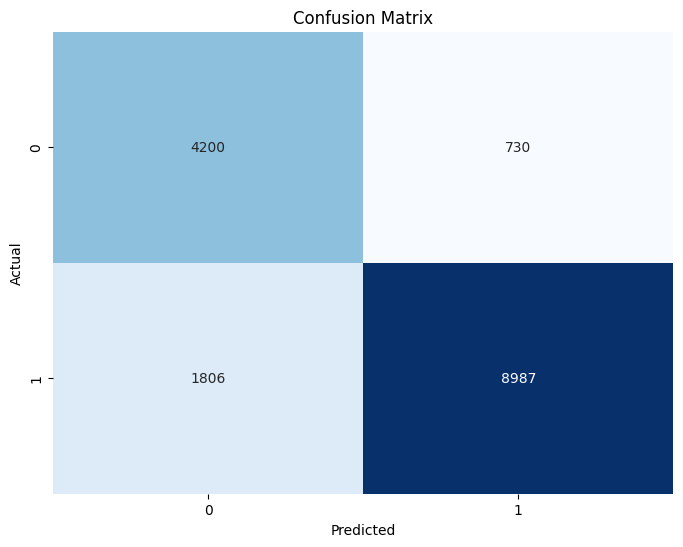

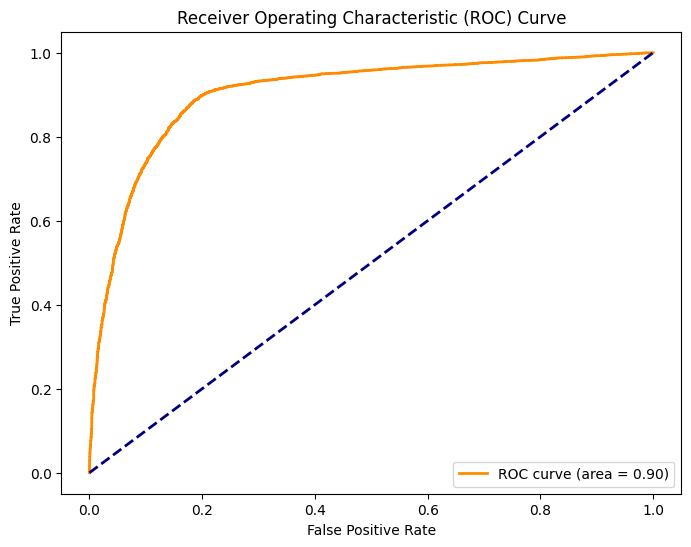

Accuracy: 0.8387
Precision: 0.9249
Recall: 0.8327
F1 Score: 0.8764
ROC-AUC Score: 0.9043


In [186]:
def evaluate_model_performance(model, X_test, y_test, sample_size=20):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Display actual and predicted labels for a representative sample
    print("Thực tế\t|\tDự đoán")
    print("-" * 30)
    for true_label, pred_label in zip(y_test[:sample_size], y_pred[:sample_size]):
        print(f"{true_label}\t|\t{pred_label}")

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Display metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC-AUC Score: {roc_auc:.4f}')

# Assuming lr_model_smote is your trained model
evaluate_model_performance(lr_model_smote, X_test, y_test, sample_size=20)


# VIII. Hyperparameter Tuning

Sử dụng Grid Search để tìm tham số phù hợp nhất (đây là cách được nhiều nghiên cứu trước áp dụng)